In [6]:
import torch
import torch.nn as nn
from model import MLP
from config import Config
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# Load configuration
config = Config()

# Initialize the model with the same architecture
model = MLP(
    input_size=config.input_size,
    hidden_sizes=config.hidden_sizes,
    output_size=config.output_size,
)

# Load the trained weights
checkpoint_path = 'results/mnist_mlp.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint)
model.eval()

MLP(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [7]:
# Define the same transforms used during training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load test dataset
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of test batches: {len(test_loader)}")

Test dataset size: 10000
Number of test batches: 100


In [8]:
def display_predictions(model, test_loader, num_samples=10, device='cpu'):
    """
    Display test images with their predictions.
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        num_samples: Number of samples to display
        device: Device to run inference on
    """
    model.to(device)
    model.eval()
    
    # Get a batch of data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    # Take first num_samples
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)
        confidence = torch.max(probabilities, dim=1)[0]
    
    # Convert to numpy for plotting
    images_np = images.numpy()
    labels_np = labels.numpy()
    predicted_np = predicted.cpu().numpy()
    confidence_np = confidence.cpu().numpy()
    
    # Create subplot
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    
    for i in range(num_samples):
        # Display image
        ax_img = axes[0, i] if num_samples > 1 else axes[0]
        img = images_np[i].squeeze()  # Remove channel dimension
        
        # Denormalize the image
        img = img * 0.3081 + 0.1307
        img = np.clip(img, 0, 1)
        
        ax_img.imshow(img, cmap='gray')
        ax_img.set_title(f'True: {labels_np[i]}\nPred: {predicted_np[i]}\nConf: {confidence_np[i]:.2f}')
        ax_img.axis('off')
        
        # Color code based on correctness
        if labels_np[i] == predicted_np[i]:
            ax_img.set_title(ax_img.get_title(), color='green', fontweight='bold')
        else:
            ax_img.set_title(ax_img.get_title(), color='red', fontweight='bold')
    
    # Add row labels
    if num_samples > 1:
        axes[0, 0].set_ylabel('Test Images', fontsize=12, rotation=0, ha='right', va='center')
    else:
        axes[0].set_ylabel('Test Images', fontsize=12, rotation=0, ha='right', va='center')
    
    plt.suptitle('Model Predictions on Test Data', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    correct = (labels_np == predicted_np).sum()
    accuracy = correct / num_samples * 100
    print(f"Accuracy on displayed samples: {accuracy:.1f}% ({correct}/{num_samples})")
    
    return images_np, labels_np, predicted_np, confidence_np

Using device: cuda


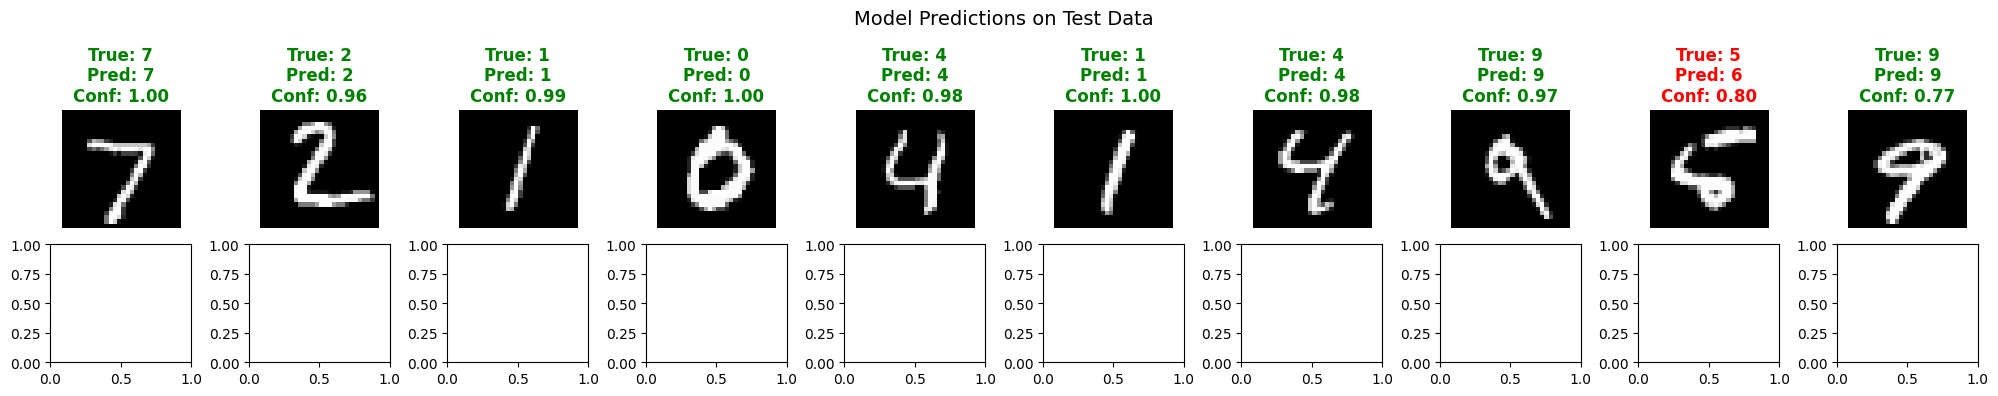

Accuracy on displayed samples: 90.0% (9/10)


In [9]:
# Display 10 test images with predictions
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

images, true_labels, predictions, confidences = display_predictions(
    model, test_loader, num_samples=10, device=device
)